In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from math import *
import pickle
import pandas as pd
from tqdm import tqdm
from aero_info import *
from missile_gym import MissileGym
from ipywidgets import interact, interactive, fixed
import ipywidgets
from matplotlib.pylab import figure, subplot2grid

In [2]:
opts = {
    'm_0': 2402.896642527979,
    'd': 0.515,
    'vel_abs': 1410,
    't_marsh': 11.602913766241713,
    'w_marsh': 1417.7090190915076,
    'P_marsh': 329901.12903225806,
    'dt': 0.01,
    'tau': 1/20,
    't_max': 150,
    'I': 2700,
    'r_kill': 50,
    'alpha_max': 20,
    'speed_change_alpha': 64,
    'xi': 0.5,
    'am': 6,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'Q_0': 75, 'pos_0': (0, 0)},
    'L_korp': 7690 / 1e3,
    'L_cil': 4567 / 1e3,
    'L_korm': 135 / 1e3,
    'L_oper': 1200 / 1e3,
    'L_kon1': 1360 / 1e3,
    'L_kon2': 1628 / 1e3,
    'b_0_oper': 1360.030793 / 1e3,
    'x_b_oper': 6.5,
    'a': 0.2,
    'betta_kon2': 1,
    'd_korm': 515 / 1e3,
    'c_oper': 0.03,
    'khi_pk_oper': 50,
    'khi_rul': 90,
    'class_korp': 7,
    'class_oper': 5,
    'S_oper': 1.20092864206,
    'x_ct_0': 4.5066951078603825,
    'x_ct_marsh': 3.921345267027331,
}

In [18]:
def foo_gym_hit(mis_opts, trg_pos, trg_vel, aero=False, record=False):
    """
    Функция тренажера огня, моделирующая движение ц.м. ракеты к цели с заданным простым постоянным вектором скорости
    arguments: mis_opts {dict} -- параметры ракеты
               trg_pos {tuple/list/np.ndarray} -- положение цели
               trg_vel {tuple/np.ndarray} -- скорость цели
    keyword arguments: aero {bool} -- включатель расчета аэродинамических коэффициентов ракеты во время ее
                                      полета ракеты по кинематической траектории {default: False}
                       record {bool} -- включатель записи результатов (состояний) моделирования шагов по времени,
                                        иначе возвращается последнее состояние моделирования {default: False}
    returns: {dict} if record = True
             (tuple) if record = False
    """
    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    done = False
    obs = gym.reset()
    state = gym.get_state()
    history = [(state, obs, done, {}, {})]
    alphas_targeting = [0]
    
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        aero_res = gym.get_aero_constants() if aero == True else {}
        if record == True:
            history.append((state, obs, done, info, aero_res))
            alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alpha_max else copysign(gym.missile.alpha_max, gym.missile.alpha_targeting))
    
    inf = info['done_reason']
    print(f'info = {inf}')
    
    if record == True:
        mis_vs, mis_xs, mis_ys, mis_vels, alphas, Qs = [], [], [], [], [], []
        trg_xs, trg_ys, trg_vs, trg_vels = [], [], [], []
        infos, aeros, ts = [], [], []
        
        for state, obs, done, info, aero_res in history:
            gym.set_state(state)
            mis_smry = gym.missile.get_summary()
            trg_smry = gym.target.get_summary()
            mis_xs.append(mis_smry['x'])
            mis_ys.append(mis_smry['y'])
            trg_xs.append(trg_smry['x'])
            trg_ys.append(trg_smry['y'])
            ts.append(mis_smry['t'])
            mis_vs.append(mis_smry['v'])
            trg_vs.append(trg_smry['v'])
            alphas.append(mis_smry['alpha'])
            Qs.append(mis_smry['Q'])
            trg_vels.append(gym.target.vel)
            mis_vels.append(gym.missile.vel)
            aeros.append(aero_res)
            infos.append(info)

        trg_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nys += [trg_nys[-1]]
        mis_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nys += [trg_nys[-1]]

        trg_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nxs += [trg_nxs[-1]]
        mis_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nxs += [trg_nxs[-1]]
    
        dict_res = {
            't': ts,
            'missile': {'v': mis_vs, 'x': mis_xs, 'y': mis_ys, 'Q': Qs, 'alpha': alphas, 'nx': mis_nxs, 'ny': mis_nys, 'vel': mis_vels},
            'target': {'v': trg_vs, 'x': trg_xs, 'y': trg_ys, 'ny': trg_nys, 'nx': trg_nxs, 'vel': trg_vels},
            'alpha_targeting': alphas_targeting,
            'aero': aeros,
            'info': infos 
        }
    if record == True:
        return dict_res
    else:
        return state, obs, done, info, aero_res

In [37]:
trg_pos = (40e3, 5e3)
trg_vel = (-450, 250)

In [38]:
%time res_hit = foo_gym_hit(opts, trg_pos, trg_vel, aero=True, record=True)

meet: True; meeting point: [29879.33440972 10622.5919946 ]
info = wrong way
Wall time: 1min 31s


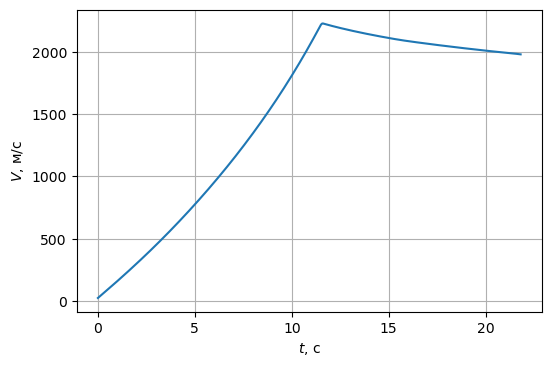

In [39]:
plt.figure(dpi=100)
plt.plot(res_hit['t'], res_hit['missile']['v'])
plt.ylabel('$V$, м/с')
plt.xlabel('$t$, с')
plt.grid()
plt.show()

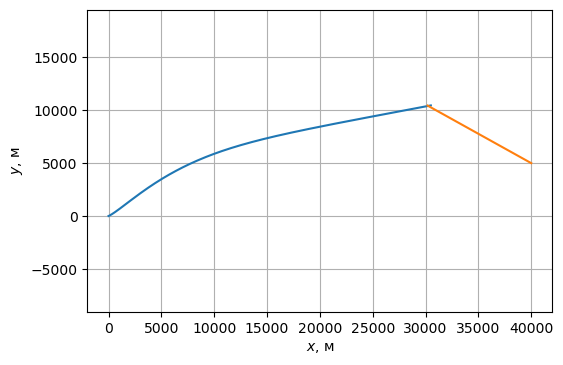

In [40]:
%matplotlib inline
plt.figure(dpi=100)
plt.plot(res_hit['missile']['x'], res_hit['missile']['y'])
plt.plot(res_hit['target']['x'], res_hit['target']['y'])
plt.grid()
plt.ylabel('$y$, м')
plt.xlabel('$x$, м')
plt.axis('equal')
plt.show()

In [41]:
Cya = []
Cx  = []
t   = []
alpha = []
for i in range(1, len(res_hit['aero'])):
    Cya.append(res_hit['aero'][i]['Cy_alpha'])
    Cx.append(res_hit['aero'][i]['Cx'])
    t.append(res_hit['aero'][i]['t'])
    alpha.append(res_hit['aero'][i]['alpha'])

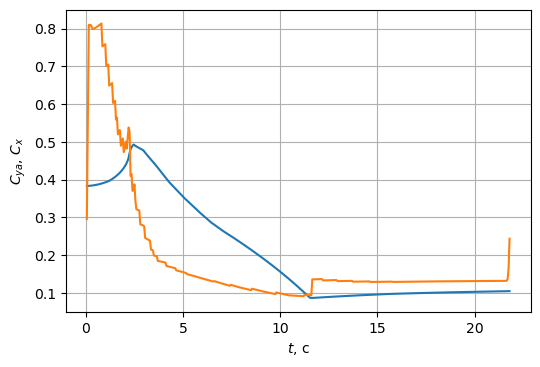

In [42]:
plt.figure(dpi=100)
plt.plot(t, Cya)
plt.plot(t, Cx)
plt.grid()
plt.ylabel('$C_{ya}$, $C_{x}$')
plt.xlabel('$t$, с')
plt.show()

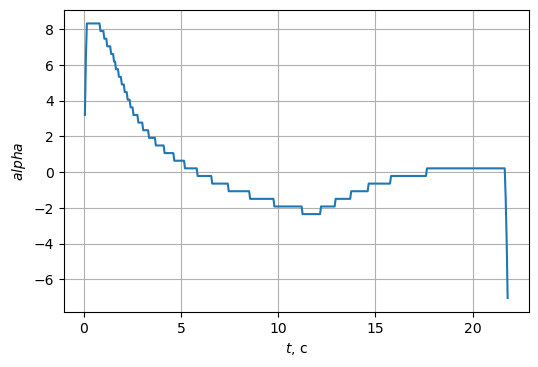

In [43]:
plt.figure(dpi=100)
plt.plot(t, alpha)
plt.grid()
plt.ylabel('$alpha$')
plt.xlabel('$t$, с')
plt.show()

In [69]:
@interact(i=ipywidgets.IntSlider(min=0, max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_gym_hit(i):
    
    plt.figure(figsize=(18,7))
    
    ax01 = subplot2grid((4, 7), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((4, 7), (0, 4), colspan=3, rowspan=1)
    ax03 = subplot2grid((4, 7), (1, 4), colspan=3, rowspan=1,sharex=ax02)
    ax04 = subplot2grid((4, 7), (2, 4), colspan=3, rowspan=1,sharex=ax02)
    ax05 = subplot2grid((4, 7), (3, 4), colspan=3, rowspan=1,sharex=ax02)
    
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['x'][:i], lw=3, ls=':', color='blue')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['x'][:i], lw=3, ls=':', color='red')
    ax01.grid(True)
    
    ax02.plot(res_hit['t'][:i], res_hit['missile']['v'][:i], label='$V_р$')
    ax02.plot(res_hit['t'][:i], res_hit['target']['v'][:i], label='$V_ц$')
    ax02.tick_params(left=False, labelleft=False, right=True, labelright=True)
    ax02.legend()
    ax02.grid(True)
    
    ax03.plot(res_hit['t'][:i], res_hit['missile']['Q'][:i], label='Q')
    ax03.tick_params(left=False, labelleft=False, right=True, labelright=True)
    ax03.legend()
    ax03.grid(True)
    
    ax04.plot(res_hit['t'][:i], res_hit['missile']['alpha'][:i], label=r'$\alpha$')
    ax04.plot(res_hit['t'][:i], res_hit['alpha_targeting'][:i], label=r'$\alpha_{пот}$', color='y', ls='-')
    ax04.tick_params(left=False, labelleft=False, right=True, labelright=True)
    ax04.legend()
    ax04.grid(True)
    
    ax05.plot(res_hit['t'][:i], res_hit['missile']['ny'][:i], label=r'$n_y$ ракеты', c='b')
    ax05.plot(res_hit['t'][:i], res_hit['missile']['nx'][:i], label=r'$n_x$ ракеты', c='b', ls='--')
    ax05.plot(res_hit['t'][:i], res_hit['target']['ny'][:i], label=r'$n_y$ цели', c='orange')
    ax05.plot(res_hit['t'][:i], res_hit['target']['nx'][:i], label=r'$n_x$ цели', c='orange', ls='--')
    ax05.legend(loc='best')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True)
    ax05.grid(True)
    
    plt.show()

interactive(children=(IntSlider(value=436, description='i', max=436), Output()), _dom_classes=('widget-interac…